In [48]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [49]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [50]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [51]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [52]:
tf.keras.backend.clear_session()

In [53]:
subject = 'Mato Grosso - Consumo de Cimento (t)'
start_index = 0
split_index = 191 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 - 30

In [54]:
data = pd.read_csv('2003_mo_model_input_MT.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Mato Grosso - Produção de Cimento (t),Mato Grosso- custo m2 (R$),Mato Grosso - IDH Longevidade,Mato Grosso - Depósito Poupança (R$),Mato Grosso - Consumo de Cimento (t),Mato Grosso - IDH Educacao,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Mato Grosso - Desemprego,Mato Grosso - IDH Renda,Mato Grosso - IDH,Mato Grosso - PIB - Estadual,Mato Grosso - PIB - Construção Civil,Mato Grosso - PIB - Per Capita,Mato Grosso - PIB - Preços de Mercado,Mato Grosso - value,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,50.917240,10522.560000,0.774167,1.402870e+06,47.470,0.713365,1.937098,994.641929,1307.693017,26.497759,22.112509,78.548056,2.038260,8.297178,0.756038,0.745147,6.084564e+07,2.670588e+06,16.831332,5.118946e+07,0.331800,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,50.851586,10614.965000,0.774487,1.418219e+06,45.387,0.713721,2.057965,994.309470,1283.219898,26.168996,21.331689,76.901685,1.862279,8.291317,0.755860,0.745308,6.092768e+07,2.672688e+06,16.835967,5.121614e+07,0.333615,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,50.970549,10702.843148,0.774808,1.433568e+06,44.907,0.714077,1.715492,994.660654,1261.062010,25.844852,20.557682,75.407092,1.802031,8.285457,0.755682,0.745469,6.100973e+07,2.674788e+06,16.840602,5.124282e+07,0.334864,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,51.049978,10785.405648,0.775128,1.448917e+06,45.467,0.714434,1.525801,995.244084,1235.995684,25.435732,19.399042,72.894611,1.794850,8.279596,0.755503,0.745630,6.109177e+07,2.676888e+06,16.845237,5.126950e+07,0.336048,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,51.567529,10863.369096,0.775449,1.464267e+06,56.246,0.714790,1.166060,995.697467,1233.790572,25.082755,17.830386,68.635209,1.820612,8.273735,0.755325,0.745791,6.117381e+07,2.678988e+06,16.849872,5.129619e+07,0.336447,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,37351.487561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,37305.538501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,37240.697573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,37158.452637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


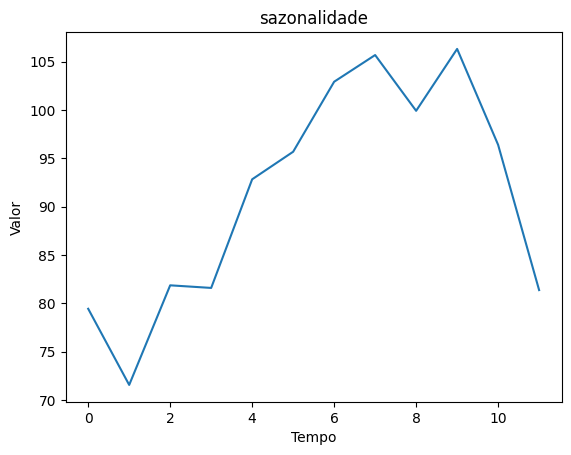

,sazonalidade
sazonalidade,
0,79.429412
1,71.551986
2,81.856015
3,81.586671
4,92.824887
5,95.675912
6,102.918231
7,105.679038
8,99.909658


In [55]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [56]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Mato Grosso - Produção de Cimento (t),Mato Grosso- custo m2 (R$),Mato Grosso - IDH Longevidade,Mato Grosso - Depósito Poupança (R$),Mato Grosso - IDH Educacao,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Mato Grosso - Desemprego,Mato Grosso - IDH Renda,Mato Grosso - IDH,Mato Grosso - PIB - Estadual,Mato Grosso - PIB - Construção Civil,Mato Grosso - PIB - Per Capita,Mato Grosso - PIB - Preços de Mercado,Mato Grosso - value,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Mato Grosso - Consumo de Cimento (t)
0,2003-1,50.917240,10522.560000,0.774167,1.402870e+06,0.713365,1.937098,994.641929,1307.693017,26.497759,22.112509,78.548056,2.038260,8.297178,0.756038,0.745147,6.084564e+07,2.670588e+06,16.831332,5.118946e+07,0.331800,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,79.429412,47.470
1,2003-2,50.851586,10614.965000,0.774487,1.418219e+06,0.713721,2.057965,994.309470,1283.219898,26.168996,21.331689,76.901685,1.862279,8.291317,0.755860,0.745308,6.092768e+07,2.672688e+06,16.835967,5.121614e+07,0.333615,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,71.551986,45.387
2,2003-3,50.970549,10702.843148,0.774808,1.433568e+06,0.714077,1.715492,994.660654,1261.062010,25.844852,20.557682,75.407092,1.802031,8.285457,0.755682,0.745469,6.100973e+07,2.674788e+06,16.840602,5.124282e+07,0.334864,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,81.856015,44.907
3,2003-4,51.049978,10785.405648,0.775128,1.448917e+06,0.714434,1.525801,995.244084,1235.995684,25.435732,19.399042,72.894611,1.794850,8.279596,0.755503,0.745630,6.109177e+07,2.676888e+06,16.845237,5.126950e+07,0.336048,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,81.586671,45.467
4,2003-5,51.567529,10863.369096,0.775449,1.464267e+06,0.714790,1.166060,995.697467,1233.790572,25.082755,17.830386,68.635209,1.820612,8.273735,0.755325,0.745791,6.117381e+07,2.678988e+06,16.849872,5.129619e+07,0.336447,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,92.824887,56.246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,37351.487561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.824887,NaN
245,2023-6,NaN,37305.538501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.675912,NaN
246,2023-7,NaN,37240.697573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102.918231,NaN
247,2023-8,NaN,37158.452637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105.679038,NaN


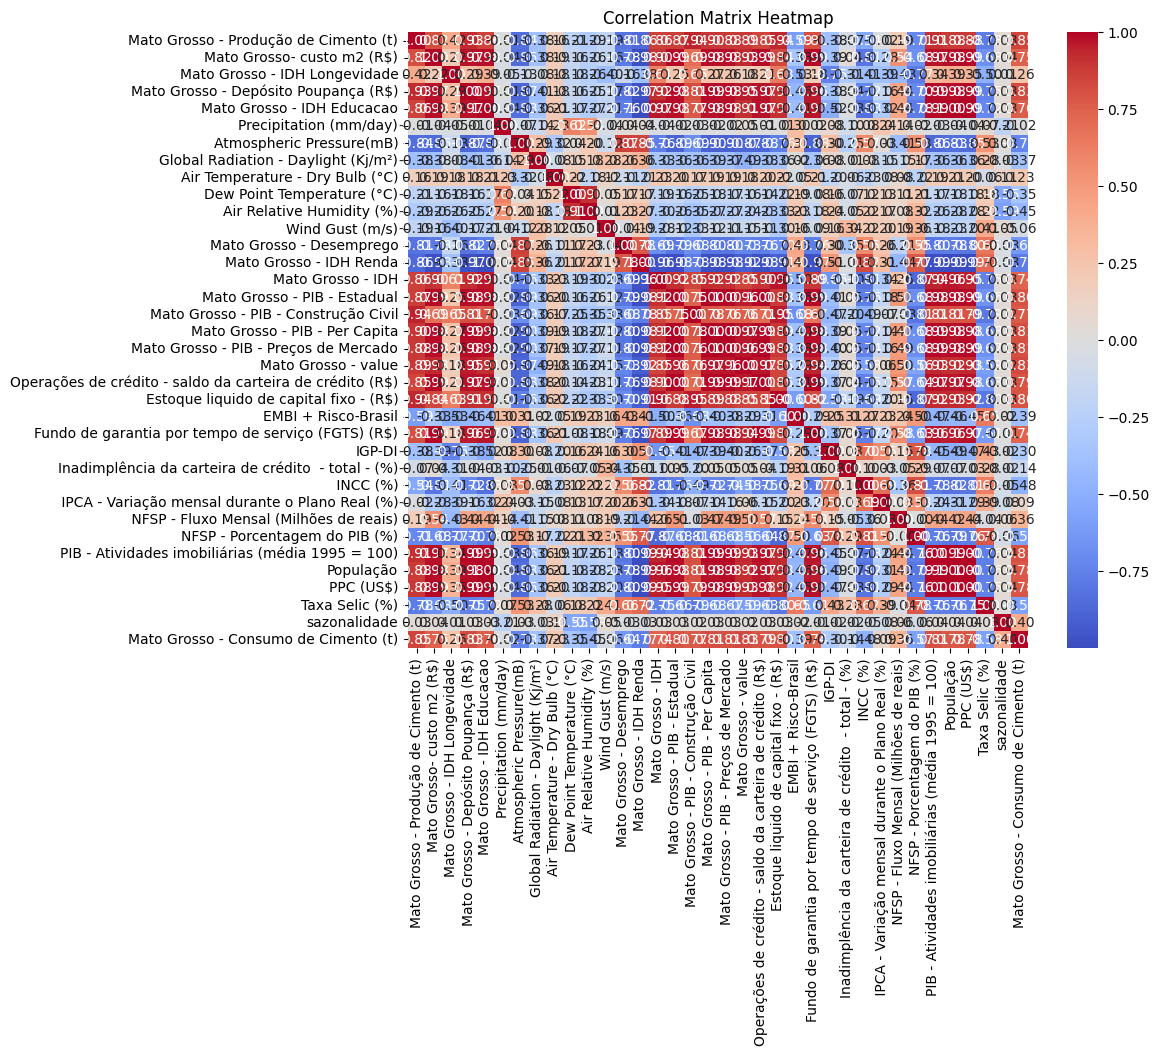

In [57]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [58]:
# data =data.drop(['Air Temperature - Dry Bulb (°C)',
#                  'Precipitation (mm/day)',
#                  'Global Radiation - Daylight (Kj/m²)', 
#                  'Air Relative Humidity (%)'], axis=1)
# data

In [59]:
input_data = data.iloc[:split_index + 1,1:-1]
# mean = np.mean(input_data, axis=0)
# stddev =  np.std(input_data, axis=0)
# input_data = ((input_data - mean) /stddev)
scaler=MinMaxScaler()
scaled_data = scaler.fit_transform(input_data)
input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Mato Grosso - Produção de Cimento (t),Mato Grosso- custo m2 (R$),Mato Grosso - IDH Longevidade,Mato Grosso - Depósito Poupança (R$),Mato Grosso - IDH Educacao,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Mato Grosso - Desemprego,Mato Grosso - IDH Renda,Mato Grosso - IDH,Mato Grosso - PIB - Estadual,Mato Grosso - PIB - Construção Civil,Mato Grosso - PIB - Per Capita,Mato Grosso - PIB - Preços de Mercado,Mato Grosso - value,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,0.001009,0.000000,0.000000,0.000000,0.000000,0.336775,0.912870,0.080500,0.517405,1.000000,1.000000,0.943601,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.182887,0.000000,0.000000,0.108706,0.015290,1.000000,0.790380,1.000000,1.000000,0.310283,1.000000,0.000000,0.000000,0.000000,0.813935,0.226618
1,0.000000,0.005780,0.022270,0.005649,0.008191,0.359949,0.887077,0.078989,0.428403,0.903498,0.943223,0.859609,0.996341,0.992459,0.011805,0.005153,0.008692,0.004513,0.005346,0.195974,0.000205,0.011007,0.058377,0.004961,0.936603,0.788742,0.968938,0.921240,0.311059,0.965719,0.001556,0.007992,0.003548,0.698054,0.000000
2,0.001828,0.011277,0.044540,0.011298,0.016381,0.294285,0.914322,0.077621,0.340651,0.807838,0.891680,0.830854,0.992682,0.984919,0.023609,0.010307,0.017385,0.009026,0.010692,0.204977,0.000218,0.022015,0.100305,0.000973,0.906543,0.788333,0.948438,0.873107,0.303979,0.927412,0.003112,0.015984,0.007210,1.000000,0.296427
3,0.003049,0.016442,0.066810,0.016946,0.024572,0.257914,0.959586,0.076073,0.229895,0.664640,0.805034,0.827427,0.989023,0.977378,0.035414,0.015460,0.026077,0.013539,0.016038,0.213516,0.000375,0.033022,0.211591,0.000000,0.858675,0.787696,0.928794,0.851659,0.287789,0.885588,0.004668,0.023976,0.010957,0.629650,0.288678
4,0.011003,0.021319,0.089080,0.022595,0.032763,0.188939,0.994760,0.075937,0.134338,0.470769,0.658143,0.839723,0.985364,0.969838,0.047219,0.020613,0.034770,0.018052,0.021384,0.216392,0.000871,0.044030,0.358835,0.002281,0.824839,0.784532,0.970421,0.823277,0.294233,0.838034,0.006586,0.031968,0.014605,0.795263,0.611980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.692912,0.975779,0.383331,0.989955,0.969083,0.363180,0.185517,0.034447,0.473616,0.382418,0.412205,0.721547,0.232479,0.043553,0.768057,0.988798,0.647567,0.992324,0.990966,0.843701,0.974735,0.828698,0.187214,0.826290,0.381401,0.228511,0.005731,0.000000,0.794606,0.030808,0.978656,0.987600,0.987346,0.075260,0.981769
188,0.693045,0.981767,0.359188,0.992466,0.967681,0.457237,0.124386,0.045597,0.583810,0.522215,0.496420,0.710959,0.228761,0.043682,0.756242,0.987198,0.649169,0.991228,0.989675,0.850718,0.979913,0.823090,0.197767,0.819012,0.466609,0.204051,0.037761,0.029504,0.869001,0.027720,0.985034,0.990700,0.990952,0.052572,0.815795
189,0.701363,0.987800,0.335045,0.994977,0.966279,0.484434,0.111254,0.053649,0.580652,0.685920,0.639336,0.691975,0.225042,0.043810,0.744427,0.985598,0.650771,0.990131,0.988384,0.864656,0.987793,0.817482,0.203626,0.880142,0.530936,0.163703,0.087044,0.043125,0.879026,0.023074,0.991411,0.993800,0.994312,0.013826,1.000000
190,0.702586,0.993959,0.310902,0.997489,0.964877,0.530068,0.099285,0.056431,0.585672,0.758157,0.707155,0.691303,0.221324,0.043939,0.732612,0.983998,0.652373,0.989035,0.987094,0.878935,0.994612,0.811875,0.204541,0.957076,0.611274,0.131737,0.118264,0.059756,0.928863,0.017547,0.995706,0.996900,0.99738

In [60]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-12)
target_data

0      51.972
1      40.729
2      54.446
3      51.788
4      58.702
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Mato Grosso - Consumo de Cimento (t), Length: 249, dtype: float64

In [61]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Mato Grosso - Produção de Cimento (t),Mato Grosso- custo m2 (R$),Mato Grosso - IDH Longevidade,Mato Grosso - Depósito Poupança (R$),Mato Grosso - IDH Educacao,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Mato Grosso - Desemprego,Mato Grosso - IDH Renda,Mato Grosso - IDH,Mato Grosso - PIB - Estadual,Mato Grosso - PIB - Construção Civil,Mato Grosso - PIB - Per Capita,Mato Grosso - PIB - Preços de Mercado,Mato Grosso - value,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,0.001009,0.000000,0.000000,0.000000,0.000000,0.336775,0.912870,0.080500,0.517405,1.000000,1.000000,0.943601,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.182887,0.000000,0.000000,0.108706,0.015290,1.000000,0.790380,1.000000,1.000000,0.310283,1.000000,0.000000,0.000000,0.000000,0.813935,0.226618
1,0.000000,0.005780,0.022270,0.005649,0.008191,0.359949,0.887077,0.078989,0.428403,0.903498,0.943223,0.859609,0.996341,0.992459,0.011805,0.005153,0.008692,0.004513,0.005346,0.195974,0.000205,0.011007,0.058377,0.004961,0.936603,0.788742,0.968938,0.921240,0.311059,0.965719,0.001556,0.007992,0.003548,0.698054,0.000000
2,0.001828,0.011277,0.044540,0.011298,0.016381,0.294285,0.914322,0.077621,0.340651,0.807838,0.891680,0.830854,0.992682,0.984919,0.023609,0.010307,0.017385,0.009026,0.010692,0.204977,0.000218,0.022015,0.100305,0.000973,0.906543,0.788333,0.948438,0.873107,0.303979,0.927412,0.003112,0.015984,0.007210,1.000000,0.296427
3,0.003049,0.016442,0.066810,0.016946,0.024572,0.257914,0.959586,0.076073,0.229895,0.664640,0.805034,0.827427,0.989023,0.977378,0.035414,0.015460,0.026077,0.013539,0.016038,0.213516,0.000375,0.033022,0.211591,0.000000,0.858675,0.787696,0.928794,0.851659,0.287789,0.885588,0.004668,0.023976,0.010957,0.629650,0.288678
4,0.011003,0.021319,0.089080,0.022595,0.032763,0.188939,0.994760,0.075937,0.134338,0.470769,0.658143,0.839723,0.985364,0.969838,0.047219,0.020613,0.034770,0.018052,0.021384,0.216392,0.000871,0.044030,0.358835,0.002281,0.824839,0.784532,0.970421,0.823277,0.294233,0.838034,0.006586,0.031968,0.014605,0.795263,0.611980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,0.588452,0.806919,0.977225,0.812639,0.998409,0.614556,0.160961,0.040648,0.774460,0.887824,0.741466,0.831428,0.621493,0.001087,0.994318,0.973043,0.688394,0.986108,0.975683,0.938508,0.981805,0.956993,0.467381,0.857984,0.039971,0.643262,0.182507,0.379453,0.469629,0.024030,0.843175,0.890665,0.874793,0.365935,0.000000
158,0.582813,0.812437,0.960636,0.819184,0.996819,0.616944,0.234357,0.032268,0.483340,0.797305,0.785424,0.791149,0.596535,0.002174,0.988636,0.974495,0.684427,0.985875,0.976460,0.931775,0.978077,0.953662,0.483414,0.846039,0.027548,0.709146,0.168812,0.332832,0.458182,0.021531,0.843824,0.893949,0.878731,0.401765,0.296427
159,0.576827,0.818201,0.944048,0.825728,0.995228,0.551264,0.283480,0.027411,0.372192,0.601840,0.652419,0.788606,0.571578,0.003261,0.982954,0.975947,0.680460,0.985641,0.977238,0.924689,0.974383,0.950331,0.485402,0.830400,0.037038,0.729647,0.152959,0.313954,0.439618,0.019385,0.844473,0.897232,0.882759,0.379504,0.288678
160,0.568447,0.824038,0.927459,0.832272,0.993638,0.335005,0.315601,0.022591,0.310244,0.411864,0.510041,0.775390,0.546620,0.004348,0.977272,0.977399,0.676493,0.985408,0.978015,0.918022,0.971205,0.947000,0.480289,0.827217,0.070841,0.729821,0.137613,0.294856,0.456732,0.017671,0.844268,0.900516,0.88686

In [62]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0       51.972
1       40.729
2       54.446
3       51.788
4       58.702
        ...   
157     65.293
158     90.338
159     83.188
160    107.230
161    105.397
Name: Mato Grosso - Consumo de Cimento (t), Length: 162, dtype: float64

In [63]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [64]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(126, 36, 35)

In [65]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Mato Grosso - Produção de Cimento (t),Mato Grosso- custo m2 (R$),Mato Grosso - IDH Longevidade,Mato Grosso - Depósito Poupança (R$),Mato Grosso - IDH Educacao,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Mato Grosso - Desemprego,Mato Grosso - IDH Renda,Mato Grosso - IDH,Mato Grosso - PIB - Estadual,Mato Grosso - PIB - Construção Civil,Mato Grosso - PIB - Per Capita,Mato Grosso - PIB - Preços de Mercado,Mato Grosso - value,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
126,1.000000,0.618816,0.773716,0.886979,0.782330,0.315314,0.241827,0.051317,0.424482,0.188414,0.254053,0.811122,0.366310,0.210908,0.798772,0.815216,0.971029,0.870123,0.843018,0.868231,0.758748,0.994213,0.038989,0.611173,0.201912,0.381658,0.372054,0.612440,0.198892,0.052718,0.831584,0.780557,0.769083,0.131587,0.902346
127,0.991476,0.625395,0.763670,0.893670,0.784690,0.345117,0.179021,0.054052,0.535355,0.255572,0.272142,0.834779,0.388500,0.212425,0.797810,0.822368,0.966201,0.876689,0.849696,0.879874,0.766876,0.995177,0.054581,0.615820,0.209545,0.325565,0.375438,0.626227,0.212790,0.056653,0.834382,0.784414,0.772016,0.217266,0.981769
128,0.976090,0.632287,0.753625,0.900362,0.787049,0.423402,0.108967,0.056507,0.610980,0.470933,0.433565,0.844938,0.410690,0.213942,0.796849,0.829519,0.961372,0.883254,0.856374,0.890140,0.775150,0.996142,0.070743,0.616446,0.238038,0.273745,0.372254,0.645442,0.219584,0.060771,0.837180,0.788271,0.774681,0.241706,0.815795
129,0.962811,0.639141,0.743579,0.907053,0.789409,0.431820,0.082261,0.056634,0.541967,0.624274,0.603493,0.837060,0.432879,0.215458,0.795888,0.836671,0.956544,0.889819,0.863052,0.900472,0.786449,0.997106,0.084331,0.663874,0.249843,0.198953,0.369458,0.673151,0.215246,0.065105,0.839978,0.792128,0.777064,0.080099,1.000000
130,0.946237,0.644868,0.733533,0.913744,0.791769,0.470637,0.050960,0.057423,0.490124,0.716485,0.721753,0.832006,0.455069,0.216975,0.794926,0.843822,0.951716,0.896384,0.869730,0.912345,0.798019,0.998071,0.095511,0.722141,0.266770,0.131822,0.371547,0.699949,0.236663,0.069099,0.840204,0.795984,0.779225,0.033180,0.714587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.692912,0.975779,0.383331,0.989955,0.969083,0.363180,0.185517,0.034447,0.473616,0.382418,0.412205,0.721547,0.232479,0.043553,0.768057,0.988798,0.647567,0.992324,0.990966,0.843701,0.974735,0.828698,0.187214,0.826290,0.381401,0.228511,0.005731,0.000000,0.794606,0.030808,0.978656,0.987600,0.987346,0.075260,0.981769
188,0.693045,0.981767,0.359188,0.992466,0.967681,0.457237,0.124386,0.045597,0.583810,0.522215,0.496420,0.710959,0.228761,0.043682,0.756242,0.987198,0.649169,0.991228,0.989675,0.850718,0.979913,0.823090,0.197767,0.819012,0.466609,0.204051,0.037761,0.029504,0.869001,0.027720,0.985034,0.990700,0.990952,0.052572,0.815795
189,0.701363,0.987800,0.335045,0.994977,0.966279,0.484434,0.111254,0.053649,0.580652,0.685920,0.639336,0.691975,0.225042,0.043810,0.744427,0.985598,0.650771,0.990131,0.988384,0.864656,0.987793,0.817482,0.203626,0.880142,0.530936,0.163703,0.087044,0.043125,0.879026,0.023074,0.991411,0.993800,0.994312,0.013826,1.000000
190,0.702586,0.993959,0.310902,0.997489,0.964877,0.530068,0.099285,0.056431,0.585672,0.758157,0.707155,0.691303,0.221324,0.043939,0.732612,0.983998,0.652373,0.989035,0.987094,0.878935,0.994612,0.811875,0.204541,0.957076,0.611274,0.131737,0.118264,0.059756,0.928863,0.017547,0.995706,0.9969

In [66]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(30, 36, 35)

In [67]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [77]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=100, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=20)
#     train, train_val = validation_splitter(train_input, 7)
#     target,target_val = validation_splitter(train_target, 7)
#     display(train.shape)
#     display(train_val.shape)
#     display(target.shape)
#     display(target_val.shape)
    # Método estocástico e learning rate=0.005
#     optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(128, activation='relu', return_sequences=True, 
                                      input_shape=(train_input.shape[1], train_input.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_squared_error')   
    history = model.fit(train_input, 
                        train_target, 
                        epochs=200,
#                         validation_data=(train_val,
#                                          target_val),
                        validation_split=0.1,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [78]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][20:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [79]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[7483389, 531388640, 1977907304, 3052178850, 247244549, 3995098797, 3856342955, 145116344, 794997057, 2769642122]


Step: 0 ___________________________________________
val_loss: 41.75194549560547
winner_seed: 7483389


Step: 1 ___________________________________________
val_loss: 39.928958892822266
winner_seed: 531388640


Step: 2 ___________________________________________
val_loss: 92.51156616210938


Step: 3 ___________________________________________
val_loss: 198.871826171875


Step: 4 ___________________________________________
val_loss: 139.063232421875


Step: 5 ___________________________________________
val_loss: 39.369449615478516
winner_seed: 3995098797


Step: 6 ___________________________________________
val_loss: 982.6763305664062


Step: 7 ___________________________________________
val_loss: 19.55668830871582
winner_seed: 145116344


Step: 8 ___________________________________________
val_loss: 326.4954833984375


Step: 9 ___________________________________________
val

In [80]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/200
4/4 [==============================] - 2s 108ms/step - loss: 11612.1914 - val_loss: 10086.7617
Epoch 2/200
4/4 [==============================] - 0s 45ms/step - loss: 10451.6562 - val_loss: 806372.3125
Epoch 3/200
4/4 [==============================] - 0s 47ms/step - loss: 9514.0840 - val_loss: 679.2498
Epoch 4/200
4/4 [==============================] - 0s 46ms/step - loss: 3975.5930 - val_loss: 54523.7969
Epoch 5/200
4/4 [==============================] - 0s 46ms/step - loss: 3093.7827 - val_loss: 552.5652
Epoch 6/200
4/4 [==============================] - 0s 45ms/step - loss: 1887.3816 - val_loss: 10028.6416
Epoch 7/200
4/4 [==============================] - 0s 48ms/step - loss: 954.6075 - val_loss: 357.4295
Epoch 8/200
4/4 [==============================] - 0s 48ms/step - loss: 622.0082 - val_loss: 2984.7905
Epoch 9/200
4/4 [==============================] - 0s 49ms/step - loss: 475.0920 - val_loss: 2370.4404
Epoch 10/200
4/4 [==============================] - 0s 49ms/st

4/4 [==============================] - 0s 51ms/step - loss: 86.7020 - val_loss: 227.9817
Epoch 78/200
4/4 [==============================] - 0s 50ms/step - loss: 99.5582 - val_loss: 221.0628
Epoch 79/200
4/4 [==============================] - 0s 50ms/step - loss: 86.4648 - val_loss: 221.5595
Epoch 80/200
4/4 [==============================] - 0s 49ms/step - loss: 75.5446 - val_loss: 136.5240
Epoch 81/200
4/4 [==============================] - 0s 50ms/step - loss: 76.7678 - val_loss: 279.9296
Epoch 82/200
4/4 [==============================] - 0s 48ms/step - loss: 79.8800 - val_loss: 135.8391
Epoch 83/200
4/4 [==============================] - 0s 49ms/step - loss: 81.6180 - val_loss: 289.6380
Epoch 84/200
4/4 [==============================] - 0s 49ms/step - loss: 66.3725 - val_loss: 162.7225
Epoch 85/200
4/4 [==============================] - 0s 47ms/step - loss: 80.9491 - val_loss: 253.8138
Epoch 86/200
4/4 [==============================] - 0s 47ms/step - loss: 79.6920 - val_loss: 17

4/4 [==============================] - 0s 43ms/step - loss: 50.6611 - val_loss: 63.5459
Epoch 158/200
4/4 [==============================] - 0s 43ms/step - loss: 51.8025 - val_loss: 245.2476
Epoch 159/200
4/4 [==============================] - 0s 45ms/step - loss: 66.4477 - val_loss: 64.9782
Epoch 160/200
4/4 [==============================] - 0s 43ms/step - loss: 60.8338 - val_loss: 131.4737
Epoch 161/200
4/4 [==============================] - 0s 49ms/step - loss: 48.8917 - val_loss: 65.1918
Epoch 162/200
4/4 [==============================] - 0s 49ms/step - loss: 56.1148 - val_loss: 78.6623
Epoch 163/200
4/4 [==============================] - 0s 45ms/step - loss: 50.7457 - val_loss: 185.3430
Epoch 164/200
4/4 [==============================] - 0s 45ms/step - loss: 54.5931 - val_loss: 67.3777
Epoch 165/200
4/4 [==============================] - 0s 46ms/step - loss: 59.6789 - val_loss: 170.9089
Epoch 166/200
4/4 [==============================] - 0s 42ms/step - loss: 59.0651 - val_loss

In [81]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [82]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 20ms/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12,Month-13,Month-14,Month-15,Month-16,Month-17,Month-18,Month-19,Month-20,Month-21,Month-22,Month-23,Month-24,Month-25,Month-26,Month-27,Month-28,Month-29,Month-30
Prediction,126.678932,130.327789,126.203369,137.491348,119.845428,100.112885,94.117569,88.421814,102.558388,107.485634,120.012489,123.296005,135.001816,138.367233,133.544388,143.353348,124.947952,103.350761,101.009758,97.775993,112.755074,116.282417,131.468918,135.586716,150.719254,151.760193,144.846115,152.62291,134.247665,110.050682
Target,120.055,125.769,112.904,123.201,112.725,90.828,96.36,86.444,94.285,98.986,88.072,141.01,122.652,142.145,121.124,130.503,104.115,90.69,102.685,96.144,102.197,106.712,124.057,124.625,133.116,144.31,140.357,152.769,124.038,95.054
Error,6.623932,4.558792,13.29937,14.290352,7.12043,9.284882,2.242432,1.977814,8.273384,8.499634,31.940491,17.713989,12.349815,3.777771,12.420387,12.850342,20.832954,12.660759,1.67524,1.631996,10.558075,9.570419,7.411919,10.961716,17.603256,7.450195,4.48912,0.146088,10.209663,14.996681


In [83]:
display(mae)
display(mape)

9.9140625

0.0899168

In [84]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [85]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 20ms/step
Ano-0: |Prediction[[1376.5516]] - Target[1290.639]| =  Error: [[85.9126]]; MAPE:[[0.06656594]]
1/1 [==============================] - 0s 19ms/step
Ano-0: |Prediction[[1473.4443]] - Target[1367.6490000000001]| =  Error: [[105.79529]]; MAPE:[[0.07735558]]
1/1 [==============================] - 0s 20ms/step
Ano-5: |Prediction[[844.2468]] - Target[789.644]| =  Error: [[54.602844]]; MAPE:[[0.06914869]]


[array([[85.9126]], dtype=float32),
 array([[105.79529]], dtype=float32),
 array([[54.602844]], dtype=float32)]

82.10358

0.071023405